# NEW NETWORK

## Goal : 
The goal of this network is to group every user we got from the scrapped tweets and their friends (e.g people they are following) and go through different step to show :
* What kind of connection they share (bipartite or small world)
* If they follow the same people or not ? What does that mean ?
* Do they belong to the same community ? 

# Let's begin

In [2]:
#import tools for twitter API
from twitter import *

In [3]:
properties = dict(line.strip().split('=') 
          for line in open('keys.properties') 
          if not line.startswith('#') and not line.startswith('\n'))

In [7]:
CONSUMER_KEY = 'CONSUMER_KEY'
CONSUMER_SECRET = 'CONSUMER_SECRET'
OAUTH_TOKEN = 'OAUTH_TOKEN-lkfIU5F9uWRwwfnR7XiDlY5b1cOoAoe'
OAUTH_TOKEN_SECRET = 'OAUTH_TOKEN_SECRET'

In [8]:
# load our API credentials 
twitter = Twitter(
    auth = OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET, CONSUMER_KEY, CONSUMER_SECRET))

In [9]:
#Credentials for tweepy (use it as complement)
import tweepy

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

api = tweepy.API(auth)

# Get the users from Mongo DB

For more efficiency we used Mongo data base to store all of our datas so they are available by anyone at anytime.

In [10]:
# import Mongo for python
import pymongo, pprint
from pymongo import MongoClient

In [11]:
properties = dict(line.strip().split('=') 
          for line in open('db.properties')
          if not line.startswith('#') and not line.startswith('\n'))

In [12]:
uri = 'mongodb://%s:%s@ds161487.mlab.com:61487/election_tweets' % (properties['username'], properties['password'])
client = MongoClient(uri)

In [13]:
db = client.election_tweets
tweet_collection = db.tweets
user_collection = db.users

In [14]:
print user_collection.count()

87501


# Create the network

Now that everything is settled we can start working on our tweet. 

In [1]:
#Import everything useful for networks
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
import json
import time
import datetime
import os
import pickle

In [20]:
# Create the graph
directed = nx.DiGraph()

In [21]:
# All twitter users in the database
users = user_collection.find()

In [22]:
for i in users:
    # We need to deal with the rate limit of twitter API
    # It's not the best way but it works and we don't really need more
    try:
        #select the user name
        user = api.get_user(i["_id"])
        username = user.screen_name

        # perform a basic search 
        query = twitter.friends.ids(screen_name = username)
        print "found %d friends" % (len(query["ids"]))

        # now we loop through them to pull out more info, in blocks of 100.
        for n in range(0, len(query["ids"]), 100):
            ids = query["ids"][n:n+100]

            # create a subquery, looking up information about these users
            subquery = twitter.users.lookup(user_id = ids)

            for user_q in subquery:
                # now print out user info, starring any users that are Verified.
                directed.add_node(user_q["screen_name"])
                directed.add_edge(username, user_q["screen_name"])
                #print " [%s] %s" % ("*" if user["verified"] else " ", user["screen_name"])
    except Exception as e:
        #Sleep while we cannot access twitter
        print "Rate Limit Error: %s" % e
        time.sleep(15 * 60 + 15)
        continue

Rate Limit Error: Twitter sent status 429 for URL: 1.1/friends/ids.json using parameters: (oauth_consumer_key=UAclDqCOIjWcR18OM33tFpUko&oauth_nonce=10275620091893754421&oauth_signature_method=HMAC-SHA1&oauth_timestamp=1480501680&oauth_token=771302832909746176-lkfIU5F9uWRwwfnR7XiDlY5b1cOoAoe&oauth_version=1.0&screen_name=Sttephy&oauth_signature=JNOS9HZ6YPVnjBKtexa5jfdE7V0%3D)
details: {u'errors': [{u'message': u'Rate limit exceeded', u'code': 88}]}
found 255 friends
found 165 friends
found 431 friends
found 911 friends
found 165 friends
found 5000 friends
found 253 friends
found 1265 friends
found 195 friends
found 650 friends
found 398 friends
found 167 friends
found 5000 friends
found 347 friends
found 26 friends
Rate Limit Error: Twitter sent status 429 for URL: 1.1/friends/ids.json using parameters: (oauth_consumer_key=UAclDqCOIjWcR18OM33tFpUko&oauth_nonce=12607340402452339246&oauth_signature_method=HMAC-SHA1&oauth_timestamp=1480502742&oauth_token=771302832909746176-lkfIU5F9uWRwwfnR

CursorNotFound: Cursor not found, cursor id: 5308878337434

** Draw is way too expensive, we have to do some work on the graph before. But first we save the network as a txt file so we won't have to run the code again **

In [34]:
import pickle
#Saving the network
pickle.dump(directed, open('graph.txt', 'w'))

In [43]:
#Open the network
directed = pickle.load(open('./graph.txt'))

# Basic Stats

In [4]:
import numpy as np
%matplotlib inline 

In [56]:
#Number of node
print ("The graph has ", directed.number_of_nodes()," node and ", directed.number_of_edges(), "edges.")


#Top 10 account by in and out degree
node_in_degree_tuples = sorted([(node, directed.in_degree(node)) for node in directed.nodes()], key=lambda (n, d): -d)
node_out_degree_tuples = sorted([(node, directed.out_degree(node)) for node in directed.nodes()], key=lambda (n, d): -d)

print (node_in_degree_tuples[:10])
print (node_out_degree_tuples[:10])




The graph has  64728  node and  78788 edges.
[(u'wikileaks', 30), (u'BarackObama', 27), (u'realDonaldTrump', 27), (u'HillaryClinton', 24), (u'POTUS', 24), (u'BernieSanders', 23), (u'KellyannePolls', 22), (u'mike_pence', 22), (u'DRUDGE_REPORT', 21), (u'RealBenCarson', 21)]
[(u'sallykohn', 4736), (u'ladygaga', 4557), (u'wikileaks', 4527), (u'StevenTDennis', 4507), (u'stuartpstevens', 4399), (u'Shottyisms', 3415), (u'bad_bad_bernie', 2986), (u'CaptainsLog2016', 2906), (u'SanFranMoman', 2692), (u'Trevor90666770', 2541)]


* The following section draws the distribution graphs.

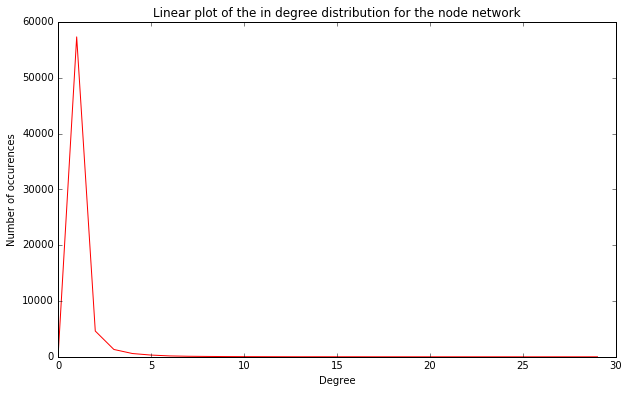

In [47]:
#Distributions
# Compute min and max values for the degrees
node_in_degree = map(lambda x: x[1], node_in_degree_tuples)
node_out_degree = map(lambda x: x[1], node_out_degree_tuples)
max_in_degree = max(node_in_degree)
min_in_degree = min(node_in_degree)
max_out_degree = max(node_out_degree)
min_out_degree = min(node_out_degree)

# Compute the bins for our degree distribution
bins_in = [i for i in range(min_in_degree, max_in_degree+1)]
bins_out = [i for i in range(min_out_degree, max_out_degree+1)]

degrees_in_hist, degrees_in_bin = np.histogram(node_in_degree, bins=bins_in)
degrees_out_hist, degrees_out_bin = np.histogram(node_out_degree, bins=bins_out)

plt.figure(figsize=(10,6))
plt.plot(degrees_in_bin[:-1], degrees_in_hist, 'r')
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Linear plot of the in degree distribution for the node network')
plt.show()

<center> ** Figure 1 ** </center>

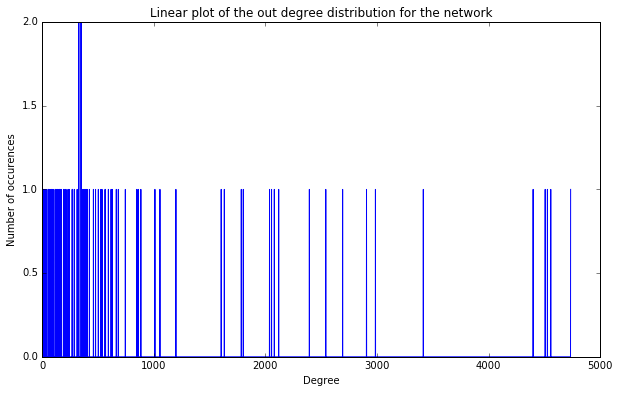

In [48]:
plt.figure(figsize=(10,6))
plt.plot(degrees_out_bin[:-1], degrees_out_hist, 'b')
plt.axis([0, 5000, 0, 2])
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Linear plot of the out degree distribution for the network')
plt.show()

<center> ** Figure 2 ** </center>

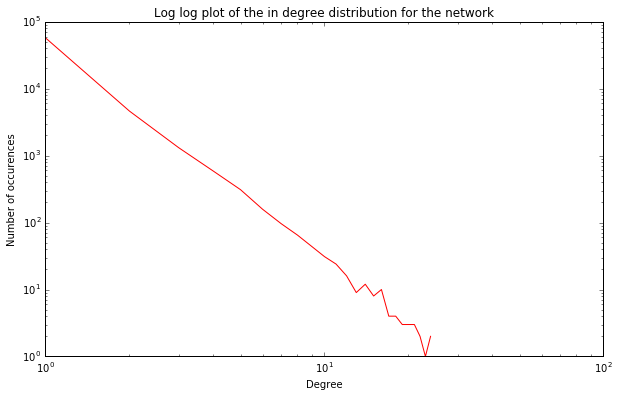

In [49]:
plt.figure(figsize=(10,6))
plt.loglog(degrees_in_bin[:-1], degrees_in_hist, 'r')
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Log log plot of the in degree distribution for the network')
plt.show()

<center> ** Figure 3 ** </center>

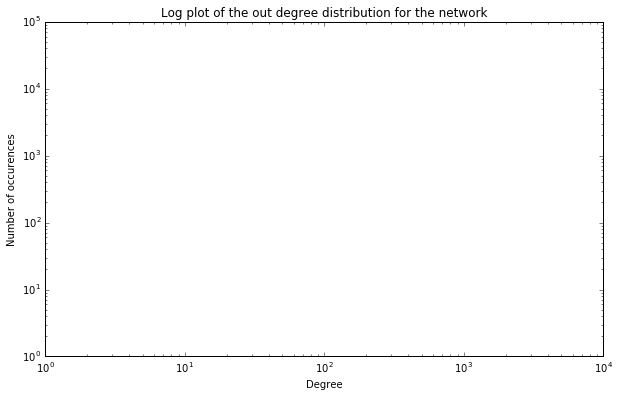

In [50]:
plt.figure(figsize=(10,6))
plt.loglog(degrees_out_bin[:-1], degrees_out_hist)
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Log plot of the out degree distribution for the network')
plt.show()



<center> ** Figure 4 ** </center>

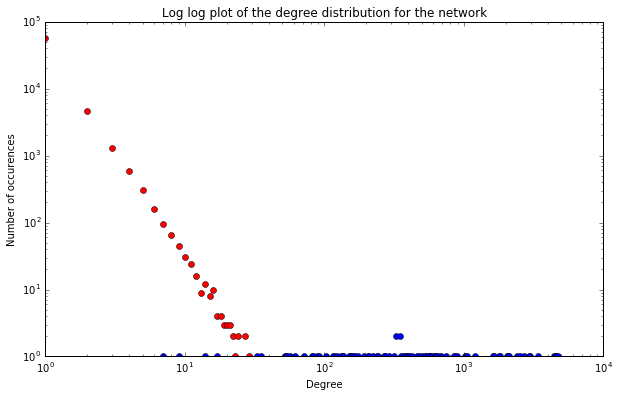

In [51]:
plt.figure(figsize=(10,6))
plt.loglog(degrees_in_bin[:-1], degrees_in_hist, 'ro')
plt.loglog(degrees_out_bin[:-1], degrees_out_hist, 'o')
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Log log plot of the degree distribution for the network')
plt.show()

<center> ** Figure 5 ** </center>

## Conclusion on distributions

In Figure 1 we can see that the most common in degree is 2, with more than 50k occurences, but after 6 in degree it seems we have no more nodes. However the out degree distribution is way broader. very few users have the same out degree but it goes from 0 to roughly 5000.

The in degree distributions seem to approach a power-law as we can see the long tail (Figure 3) at the begining where the number of nodes with low degrees is really high and then it decreases as  a power-law (with a few fluctuations that mean we have a few high influential individuals that have a lot of followers).


We can see that the in-degrees and out-degrees do not follow the same curve. This means that we can't expect to have as many connections coming in than coming out. And this interpretation makes sense as our network was build from a social media platform : we tend to follow more people than we have followers. The red curve in Figure 5 confirms our thoughts about the in degree distribution, it follows a power law. On the other hand, the blue curve (and the out degree distributions in general) is pretty chaotic, we can't tell if it follows any particular distribution.

# Centrality and other stuffs

* The following section draws the graph and weigth the size of a node according to its degree. The plot itself is not really important, but it looks cool !

The graph is way too big to be drawn, so we decide to make a smaller graph. The idea is to keep the node with a degree greater than 3 only. We have a lot of isolated accounts that are quite useless in this centrality analysis.

In [52]:
#Compute a list of nodes with a degree < 1 to remove
to_remove = [node for node,degree in dire.degree().items() if degree < 3]

In [53]:
# We make a copy of the original graph
test = directed.copy()

In [54]:
#We remove the nodes
test.remove_nodes_from(to_remove)

In [59]:
#Number of node
print("The graph has now " , test.number_of_nodes() , "nodes and and ", test.number_of_edges(), "edges.")


#Top 10 account by in and out degree
node_in_degree_tuples = sorted([(node, test.in_degree(node)) for node in test.nodes()], key=lambda (n, d): -d)
node_out_degree_tuples = sorted([(node, test.out_degree(node)) for node in test.nodes()], key=lambda (n, d): -d)
print ("The top ten accounts by in degree are : ")
print (node_in_degree_tuples[:10])
print ("The top ten accounts by out degree are : ")
print (node_out_degree_tuples[:10])

The graph has now  2785 nodes and and  12228 edges.
The top ten accounts by in degree are : 
[(u'wikileaks', 30), (u'realDonaldTrump', 27), (u'BarackObama', 27), (u'POTUS', 24), (u'HillaryClinton', 24), (u'BernieSanders', 23), (u'mike_pence', 22), (u'KellyannePolls', 22), (u'DRUDGE_REPORT', 21), (u'RealBenCarson', 21)]
The top ten accounts by out degree are : 
[(u'sallykohn', 885), (u'StevenTDennis', 777), (u'stuartpstevens', 733), (u'Trevor90666770', 726), (u'sanchezcan', 724), (u'kurteichenwald', 655), (u'PPolenberg', 439), (u'halsteadg048', 405), (u'jojoh888', 351), (u'bad_bad_bernie', 317)]


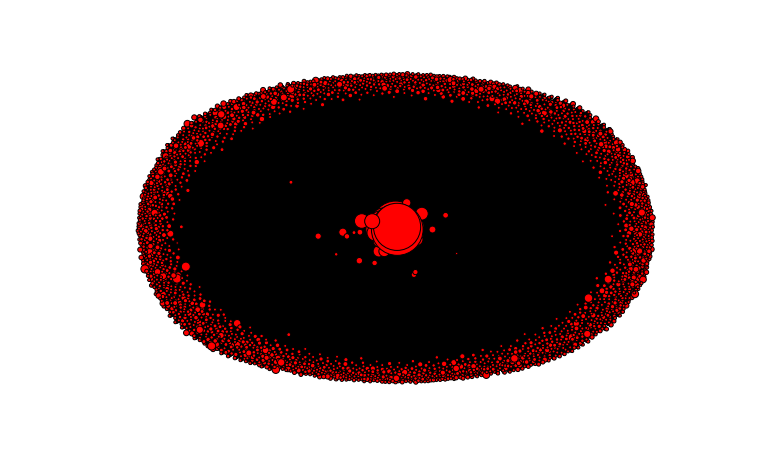

In [74]:
#We can now plot the network 
plt.figure(figsize=(10,6))
d = nx.degree(test)
nx.draw(test, nodelist=d.keys(), node_size=[v * 3 for v in d.values()])
plt.savefig("graph.pdf")
plt.show()

<center> Figure 6 </center>

As we were exepecting, it seems like we have a few central accounts and thousands of smaller ones gravitating aroung them. To learn more about these central accounts we will now go through some centrality measures. We perform these algorithms on the reduced network as these measures are very costly 

In [62]:
# We need an undirectd graph
undir = test.to_undirected()

In [81]:
#Betweeness centrality
between_centrality = nx.betweenness_centrality(undir)
between_centrality_sorted = sorted(between_centrality.iteritems(), key=lambda (name, value): -value)

print "Betweenes : The 5 most central accounts are :\n" 
print between_centrality_sorted[:5]

Betweenes : The 5 most central accounts are :

[(u'Trevor90666770', 0.19344522557156732), (u'sallykohn', 0.17619084394519682), (u'stuartpstevens', 0.14708972224880318), (u'StevenTDennis', 0.13828282353275367), (u'sanchezcan', 0.12851328806855555)]


Betweeness centrality measures how central a node is. Users with a high betweenness centrality may have a good followers/following ratio. We will look into these accounts later on.

In [83]:
#Eigen vector centrality
eigen_centrality = nx.eigenvector_centrality(undir)
eigen_centrality_sorted = sorted(eigen_centrality.iteritems(), key=lambda (name, value): -value)

print "Eigen : The 5 most central accounts are :\n" 
print eigen_centrality_sorted[:5]

Eigen : The 5 most central accounts are :

[(u'sallykohn', 0.3055201383264885), (u'sanchezcan', 0.27596570515958063), (u'StevenTDennis', 0.27116859006756233), (u'stuartpstevens', 0.264643703632886), (u'kurteichenwald', 0.2609156928239351)]


* Now we work on the directed graph again.

In [85]:
#In degree centrality
in_centrality = nx.in_degree_centrality(test)
in_centrality_sorted = sorted(in_centrality.iteritems(), key=lambda (name, value): -value)

print "In degree centrality : The 5 most central accounts are :\n" 
print in_centrality_sorted[:5]

In degree centrality : The 5 most central accounts are :

[(u'wikileaks', 0.010775862068965518), (u'realDonaldTrump', 0.009698275862068966), (u'BarackObama', 0.009698275862068966), (u'POTUS', 0.008620689655172414), (u'HillaryClinton', 0.008620689655172414)]


These names are familiar but...

In [86]:
#out degree centrality
out_centrality = nx.out_degree_centrality(test)
out_centrality_sorted = sorted(out_centrality.iteritems(), key=lambda (name, value): -value)

print "out degree centrality : The 5 most central accounts are :\n" 
print out_centrality_sorted[:5]

out degree centrality : The 5 most central accounts are :

[(u'sallykohn', 0.31788793103448276), (u'StevenTDennis', 0.2790948275862069), (u'stuartpstevens', 0.26329022988505746), (u'Trevor90666770', 0.2607758620689655), (u'sanchezcan', 0.2600574712643678)]


... these ones aren't. And once again, that makes sense, famous users will have more followers, but as an average person, you can follow as many people as you want !

In [94]:
#Now we want to check if there is a path between Clinton and Trump on both networks
print nx.has_path(undir, u'HillaryClinton',  u'realDonaldTrump')
print nx.has_path(test, u'HillaryClinton',  u'realDonaldTrump')

True
False


In [99]:
print nx.shortest_path_length(undir, u'HillaryClinton',  u'realDonaldTrump')
print nx.shortest_path_length(undir, u'HillaryClinton',  u'wikileaks')
print nx.shortest_path_length(undir, u'BarackObama',  u'realDonaldTrump')

2
2
2


## Conclusion on centrality

The results we have on centrality measures let us think that we have quite a good network. We have famous people with a lot of followers and Twitter addicts with a lot of "friends". It is also interesting to note that the betweeness centrality and the eigenvector centrality do not provide the exact same results. It will be interesting to see if we come across these names again when dealing with communities (and we'll see who these people actually are !).

# Problem importing community 

# Community detection

### Louvain Algorithm

To perform community detection we'll use the Louvain algorithm. The inspiration for this method of community detection is the optimization of Modularity as the algorithm progresses.  Modularity is one measure between -1 and 1 of the structure of networks. It was designed to measure the strength of division of a network into modules (also called groups, clusters or communities). Networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules. (WikipÃ©dia)

In [254]:
import community

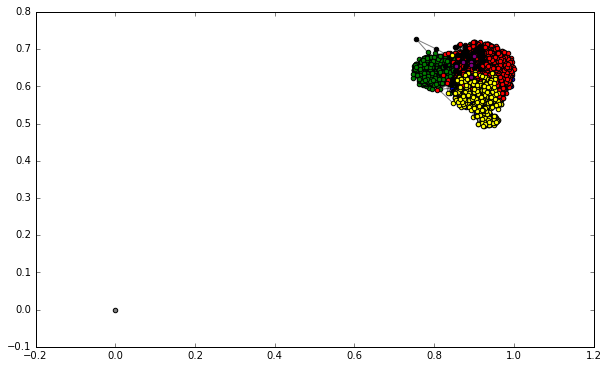

In [73]:
plt.figure(figsize=(10,6))
partition = community.best_partition(undir)
## We know after the post hoc analysis that we need only 7 color.
color_map = ['blue','green','red','black','yellow','purple','grey']
#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(undir)
count = -1
for com in set(partition.values()) :
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(undir, pos, list_nodes, node_size = 20,
                                node_color = color_map[count])

nx.draw_networkx_edges(undir,pos, alpha=0.5)
plt.savefig("partitions.pdf")
plt.show()

<center> **Figure 7** - Community partition</center>

In [68]:
louvain_modularity = community.modularity(partition, undir)
louvain_modularity

0.4032080138771301

* We got a louvain modularity of 0.4, we can say this modularity is pretty high, which means we have good partitions in our network.

The plot above is not really helping. As usual, the high number of nodes make it difficult to read. In the next block we will count our communities and then try to understand the meaning of these different groups.

In [12]:
communities = {}

# Create a dictionary of all communities and their associated user 
for user, community_index in partition.iteritems():
    if community_index in communities:
        communities[community_index].add(user)
    else:
        communities[community_index] = {user}
    
nb_communities = len(communities)
nb_communities

7

* So we have 7 different communities. We now want to try to understant what is within these communities. To do so we will extract the most important accounts (in terms of degree) in these communities.

In [15]:
pickle.dump(communities, open('community.txt', 'w'))

Here we plot the reduced graph only showing the communities and their connections.

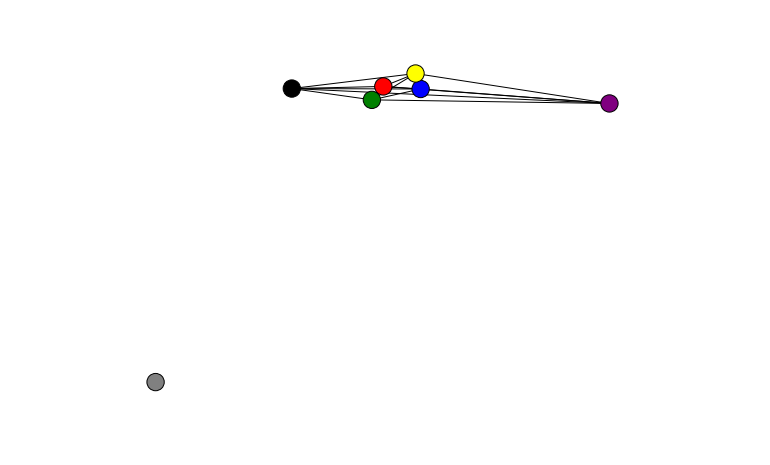

In [72]:
plt.figure(figsize=(10,6))
ind = induced_graph(partition, undir)
nx.draw(ind, node_color = color_map)
plt.savefig("communities.pdf")
plt.show()

We can see once more that one group is completely disconnected from the others. ** That is probably due to the first graph reduction (from 64k nodes to 2k nodes). ** This accounts had a lot of followers but they weren't popular so they've been removed. Now we have this isolated community while the others are connected. Let's dig into these communities.

In [220]:
com= [communities.values()[0],
    communities.values()[1],
    communities.values()[2],
    communities.values()[3],
    communities.values()[4],
    communities.values()[5],
    communities.values()[6],
]

In [253]:
#Top 10 account by in and out degree
for i in range (0,7):
    node = com[i]
    sub = test.subgraph(node)
    node_in_degree_tuples = sorted([(node, sub.in_degree(node)) for node in sub.nodes()], key=lambda (n, d): -d)
    node_out_degree_tuples = sorted([(node, sub.out_degree(node)) for node in sub.nodes()], key=lambda (n, d): -d)
    print("In community ", i)
    print("The top ten accounts by in degree are : ")
    print( node_in_degree_tuples[:10])
    print("The top ten accounts by out degree are : ")
    print( node_out_degree_tuples[:10])
    print("\n")

In community  0
The top ten accounts by in degree are : 
[(u'NASA', 10), (u'wikileaks', 9), (u'BillGates', 9), (u'washingtonpost', 9), (u'AP', 9), (u'BernieSanders', 8), (u'BBCBreaking', 8), (u'nytimes', 8), (u'guardian', 7), (u'TIME', 7)]
The top ten accounts by out degree are : 
[(u'PPolenberg', 238), (u'wikileaks', 138), (u'GreenPartyUS', 137), (u'jkoking', 93), (u'macdoodled', 82), (u'sulaimanslalani', 81), (u'Independent', 75), (u'JesseBenn', 70), (u'ajplus', 68), (u'AinDC', 58)]


In community  1
The top ten accounts by in degree are : 
[(u'JudgeJeanine', 17), (u'seanhannity', 17), (u'mike_pence', 16), (u'SheriffClarke', 15), (u'RealBenCarson', 15), (u'LouDobbs', 14), (u'DonaldJTrumpJr', 14), (u'IngrahamAngle', 14), (u'DRUDGE_REPORT', 13), (u'DineshDSouza', 13)]
The top ten accounts by out degree are : 
[(u'Trevor90666770', 508), (u'halsteadg048', 376), (u'jojoh888', 344), (u'shabeau2', 231), (u'An_Investigator', 177), (u'Sunshine420too', 132), (u'FoxNews', 112), (u'katzkab11', 7

Alright, we have a lot of informations to processe here, so we'll work community by community. Next to account's name we provide the Twitter descriptions and/or a general description.

### Community 0

According to the in degree 

* **NASA** : National Aeronautics and Space Administration 
* **wikileaks** : Publishes and comments on leaked documents alleging government and corporate misconduct.
* **BillGates** :  an American business magnate, investor, author and philanthropist.
* **washingtonpost** : Breaking news and analysis on politics, business, world national news, entertainment more.
* **AP** : The Associated Press is the essential global news network, delivering fast, unbiased news from every corner of the world to all media platforms and formats.
* **BernieSanders** : Bernie Sanders is the longest serving independent in congressional history. Ran for presidence
* **BBCBreaking** : Breaking news alerts and updates from the BBC

And then by out degree are : 

* **PPolenberg** : Peggy Polenberg Real Estate-Broker specializing in Hudson Valley Residential & Commercial sales & leases. (Anti Trump)
* **wikileaks** : ... 
* **GreenPartyUS** : Official Twitter account of the Green Party of the United States (Independant)
* **macdoodled** : short time WAC/disABLED/ Wanted2start non profit Art Therapy for vets. ART HEALS. VA / social svcs fails lowest income disabled homeless -lost all -done.
* **sulaimanslalani** : Exec Dir GEO TV Network. Syndication, acquisition, films, advocacy campaigns. Squash freak.Globetrotter. Beatles/Sinatra/Dylan/Cash. Optimist forever!
* **Independent** : News, comment and features from The Independent
* **JesseBenn** : Just some guy who writes things. Raising a rebel. Married to #1 mom. Member of the Tribe. Dissident. Leftie. Fomenting rebellion. UW J-School PhD student.
* **ajplus** : AJ+ is news for the connected generation, sharing human struggles, and challenging the status quo. 

** Conclusion ** : Looking at the results we have and the twitter account's descriptions we can spot two main ideas : ** independant** and **left**. This community is made of people who claim to be independant, unbiased, left winged and against politicians such as Donald J. Trump. It also seems that these users (the real person behind) are quite educated (PhD, Exec Dir, BUsiness, Bill Gates, Wikileaks...)

### Community 1

The top ten accounts by in degree are : 

* **JudgeJeanine** : Judge Pirro is a highly respected District Attorney, Judge, author & renowned champion of the underdog. She hosts the Fox News show, Justice with Judge Jeanine.
* **seanhannity** : TV Host Fox News Channel 10 PM. Nationally Syndicated Radio Host 3-6 PM EST
* **mike_pence** : Indiana Governor Mike Pence, Vice President-elect of the United States
* **SheriffClarke** : Sheriff Milwaukee Co. MA Security Studies NPS. NRA Member. CPAC Charlton Heston Courage Under Fire Award. NYPD/NYC Police Benevolent Asso. Person of the Year
* **RealBenCarson** : The Official Twitter Page of Dr. Ben Carson.
* **LouDobbs** : Lou Dobbs Tonight, Fox Business Network, 7 & 11 pm 
* **DonaldJTrumpJr** : EVP of Development & Acquisitions Trump Organization and Boardroom Advisor on the Apprentice.

The top ten accounts by out degree are : 

* **Trevor90666770** : Trump supporter who is NOT racist & wants to MAGA! George Soros & Hillary for Prison. Straight white cis male scum  (definitely a "troll" page)
* **halsteadg048** : Americans.. We Have A New Champion Of We The People Who Will Listen To Our Needs. God Bless America
* **jojoh888** : America will be great again with #PresidentTrump #DrainTheSwamp #BuildTheWall 
* **shabeau2** : I did not begin this journey on the Trump Train. I researched, listened, watched, read and then made an educated decision to climb aboard. Bless DJT-MAGA!
* **Sunshine420too** : Joined to be aboard the Trump Train
* **FoxNews** : Americaâ€™s Strongest Primetime Lineup Anywhere! Follow America's #1 cable news network, delivering you breaking news, insightful analysis, and must-see videos.

** Conclusion ** This community is cleary made of Trump supporters and on a larger scale, republicans. We can see a lot of FOX News TV host, a TV channel which strongly supported Trump during the campain (and still does). We also have different personnality from Trump familly, board, government... When looking at the top accounts by out degree we come accross strongly patriotic users (a lot of Star Spangled Banners and bald eagles on the pages) and Trump supporters. Two things to notice however : Trump isn't in the top account, which is a odd, and we have at least one "troll" account (Trevor90666770) and we may have some more that would probably biase the sentiment analysis. 

### Community 2

The accounts by in degree are : 
* **KeithOlbermann** : GQ Special Correspondent: THE RESISTANCE. On Bojack Horseman. Denounced by Trump. Saying nice things about Canada since 1967.
* **SenWarren** : Official twitter account of democrat Senator Elizabeth Warren of Massachusetts.
* **JoyAnnReid** : Joy Reid, is a national correspondent at MSNBC, American cable television host and political commentator.
* **elizabethforma** : United States Senator from Massachusetts. (NO)
* **politico** : Nobody knows politics like POLITICO. 
* **FLOTUS** : This account is run by the Office of First Lady Michelle Obama.
* **ChelseaClinton** : Mom, Wife, Author #ItsYourWorld, Vice-Chair/Champion of all things @ClintonFdn, @ClintonHealth, New Yorker

The accounts by out degree are : 
* **sallykohn** : Writer and CNN political commentator. Sometimes lovable dissident.
* **stuartpstevens** : Writer, political consultant, obsessive but lousy endurance sport junkie. Partner, @Strat_Media,Daily Beast columnist. Author of 7 books. 
* **StevenTDennis** : @Bloomberg reporter. Senate, politics. Ex-White House, House, Md Politics. Dad to 3, Terp, Truth-teller. Opinions are my own. 
* **sanchezcan** : Fit for knowledge, enjoy quality fÃºtbol where ever it exists, strengthen my spiritual beliefs & enjoy talented people in the arts - University of Colorado
* **kurteichenwald** : Contributing editor, Vanity Fair; senior writer, Newsweek; New York Times bestselling author.
* **JStein_Vox** : Writing politics @ http://www.Vox.com . Formerly Ithaca Voice: http://bit.ly/2awfr0K . Mats Zuccarello fan.
* **bad_bad_bernie** : Saying true things that many are too nice to say. Mostly respectful, but always direct. #NoDAPL #NeverTrump


** Conclusion ** This community is now Democrat. We have a senator, Michelle Obama and Chelsea Clinton but democrat journalists such as CNN/Bloomberg reporters. Once again we have to notice that Hillary and Obama aren't in the top accounts (also uncanny).

### Community 3

* **DavidLimbaugh** : A lawyer, columnist, and author.
* **gatewaypundit** : Blogger- Activist- - Where Hope Made a Comeback
* **BuckSexton** : Host, The Buck Sexton Show on theBlaze; Ex-CIA. Ex-NYPD Intel. 
* **MichaelBarone** : Michael Barone is Senior Political Analyst for the Washington Examiner, co-author of The Almanac of American Politics and a contributor to Fox News.
* **NolteNC** : Editor-At-Large at Daily Wire
* **kausmickey** : The End of Equality [1992, Basic Books] The venerable liberal crusade for income equality is doomed. ... Time [to] try a different strategy.

The top ten accounts by out degree are : 
* **AnnCoulter** : Ann Hart Coulter is an American conservative social and political commentator, writer, syndicated columnist, and lawyer.
* **CharlemagSteak** : Texan. Romantic Adventurer.
* **JamesEdwardsTPC** : Host of The Political Cesspool. As seen on: CNN, Fox News, MSNBC, C-SPAN, New York Times, Washington Post, Newsweek, U.K. Daily Mail, and a few hundred others.
* **starwars** : The official home of Star Wars on Twitter
* **DennisPrager** : Host of the Dennis Prager Show. Founder of @PragerU. Best-selling author. Columnist. Fan of cigars, stereo, the @LAKings and, of course, this wonderful country.
* **zerohedge** : No description 
* **RMConservative** : Senior Editor at https://www.conservativereview.com/  Conservative writer, policy analyst, 

** Conclusion ** It is really difficult to label this community. We have a lot of different users indeed. From TV host, to average users and even the star wars account... It seems this community is a big melting pot and it will be hard to get any trustworthy result, so we won't spend too much time on this one.

### Community 4

The accounts by in degree are : 
* **edsheeran** : British singer 
* **rihanna** : American singer 
* **ArianaGrande** : American singer 
* **adamlambert** : American singer 
* **NiallOfficial** : American singer 
* **onedirection** : Boys band
* **Harry_Styles**: He is known as a member of the boys band One Direction.

The accounts by out degree are : 
* **troyesivan** : Australia-based singer and actor  
* **tyleroakley** :  American YouTube and podcast personality, humorist, author and activist.
* **RandallJSharp** : Womanist | Pro-Black | SJW | My purpose in life is to help black people progress ECONOMICALLY, EDUCATIONALLY, POLITICALLY, SOCIALLY, & PSYCHOLOGICALLY #BLM
* **pshimmallama** : Bosnian ðŸ‡§ðŸ‡¦I watch way to many tv shows and I tweet about them. I ðŸ’•my ðŸ±. 
* **AshtonsFalcon** : Spelling isn't my thing nor writing a bio | multi-fandom | Noticed by my sunshines; BIEBER, CLIFFORD, OAKLEY !
* **ladygaga** : American singer
* **hollet1227** : No description. Pro Hillary 

** Conclusion ** And here comes the show business community. We have indeed a lot of singer/podcaster and of course their little fandom. We can see this community as the trendy artists followed by young people. These artist claimed to follow HIllary Clinton during the campaign.

### Community 5

* **HarvardBiz** : The leading destination for smart management thinking.
* **WSJ** : Breaking news and features from the Wall Street Journal.
* **SECNetwork** : SEC Network is an American television channel that is owned by ESPN Inc. The channel is dedicated to coverage of collegiate sports sanctioned by the Southeastern Conference (SEC) including live and recorded event telecasts, news, analysis programs, and other content focusing on the conference's member schools
* **Forbes** : Business news and financial news by Forbes.com. Core topics include business, technology, stock markets, personal finance, and lifestyle.
* **SEC** : ..
* **WSJbusiness** : ..
* **duckiller01** : No description, random account

** Conclusion ** This community seems to be focused on business and financial news. We see huge business news papers such as Forbes or the Wall Street Journal. This community is said to be neutral.

### Community 6

* jlllisaurusrex : No description

** Conclusion ** This user is unclassifiable. After going through her feed, nothing stands out but random retweet. There's no real need to consider this community.

## Conclusion on communities